In [3]:
# Step 1: Load data and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
marks_df = pd.read_csv("senior_marks.csv")
grants_df = pd.read_csv("grant_data.csv")

# Display basic info to confirm structure
print("Marks data:")
print(marks_df.info())
print(marks_df.head())

print("\nGrant data:")
print(grants_df.info())
print(grants_df.head())


C:\Users\User\AppData\Local\Temp\ipykernel_7716\1793549732.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  marks_df = pd.read_csv("senior_marks.csv")


Marks data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399981 entries, 0 to 399980
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   academic_yr         399981 non-null  int64  
 1   subject_code        399981 non-null  int64  
 2   grade_level         399078 non-null  object 
 3   credit_received     399981 non-null  float64
 4   loi                 399981 non-null  object 
 5   student_nbr_hashed  399981 non-null  int64  
 6   school_nbr_hashed   399981 non-null  int64  
 7   mark                399981 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 24.4+ MB
None
   academic_yr  subject_code grade_level  credit_received loi  \
0         2018           169         30F              1.0   1   
1         2018           108         42S              1.0   1   
2         2018           274         10S              1.0   1   
3         2019             1         10E          

In [4]:
# Define valid math subject codes
math_codes = [3909, 3900, 3907, 3903, 3000, 3001, 3004, 3005,
              3006, 3007, 3008, 3905, 3908, 3940, 3939, 3923, 3918, 3919]

# Keep only rows with math subject codes
marks_df = marks_df[marks_df["subject_code"].isin(math_codes)]


# Keep only rows with numeric marks
marks_df = marks_df[pd.to_numeric(marks_df["mark"], errors="coerce").notnull()]
marks_df["mark"] = marks_df["mark"].astype(float)

# Keep only valid languages of instruction: 1 = English, 2 = French
marks_df = marks_df[marks_df["loi"].isin([1, 2])]


In [5]:
# Merge on student ID and academic year
merged_df = pd.merge(marks_df, grants_df, on=["student_nbr_hashed", "academic_yr"], how="left")

merged_df["stu_grant_code"] = merged_df["stu_grant_code"].fillna(0)

def get_program(code):
    if code == 101:
        return "Français"
    elif code == 110:
        return "Immersion - Early"
    elif code == 112:
        return "Immersion - Late"
    elif code == 0:
        return "English"
    else:
        return "Unknown"


merged_df["program_label"] = merged_df["stu_grant_code"].apply(get_program)


print(merged_df.head())
print(merged_df["program_label"].value_counts())
# Show some Français students
print(merged_df[merged_df["program_label"] == "Français"].head())

# Show some Immersion students
print(merged_df[merged_df["program_label"].str.contains("Immersion")].head())



   academic_yr  subject_code grade_level  credit_received loi  \
0         2018          3000         40S              1.0   1   
1         2018          3000         20S              1.0   1   
2         2018          3000         40S              1.0   1   
3         2018          3000         20S              1.0   1   
4         2018          3000         40S              1.0   1   

   student_nbr_hashed  school_nbr_hashed_x  mark  stu_grant_code  \
0         -2023147862            442791482  51.0             0.0   
1          -938810957           1829357534  54.0             0.0   
2          -938810957           1829357534  72.0             0.0   
3          -656539974           -331273503  78.0             0.0   
4          -656539974           -331273503  74.0             0.0   

   school_nbr_hashed_y program_label  
0                  NaN       English  
1                  NaN       English  
2                  NaN       English  
3                  NaN       English  
4    

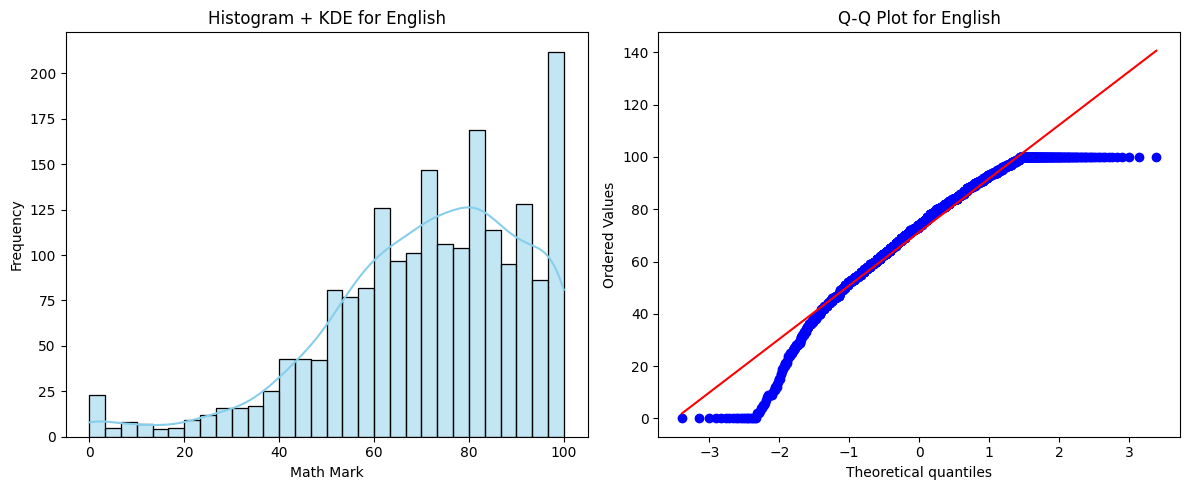

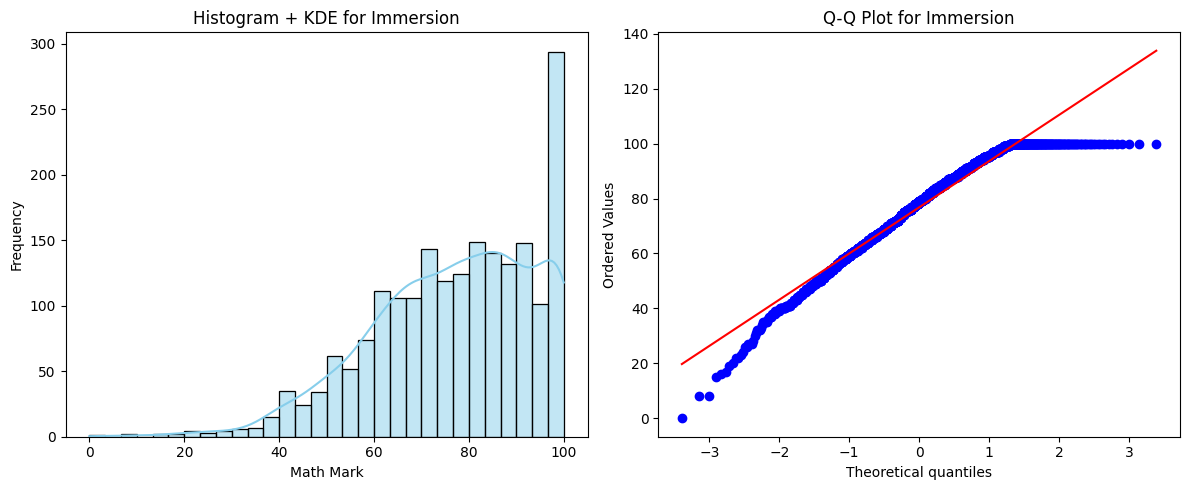

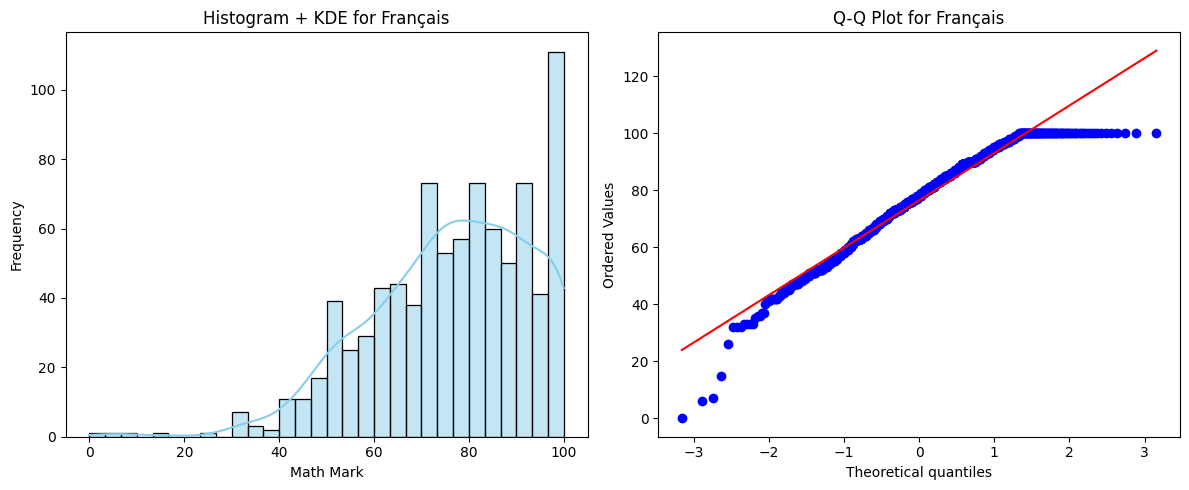

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

groups = filtered_df["program_grouped"].unique()

for group in groups:
    data = filtered_df[filtered_df["program_grouped"] == group]["mark"].dropna()
    sample = data.sample(2000, random_state=1) if len(data) > 2000 else data  # limit points for speed
    
    plt.figure(figsize=(12,5))
    
    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(sample, kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram + KDE for {group}')
    plt.xlabel('Math Mark')
    plt.ylabel('Frequency')
    
    # Q-Q Plot
    plt.subplot(1,2,2)
    stats.probplot(sample, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {group}')
    
    plt.tight_layout()
    plt.show()


In [13]:
# Calculate number and percentage of perfect scores (100) per group
perfect_scores = filtered_df[filtered_df["mark"] == 100]

# Count total students per group
total_counts = filtered_df.groupby("program_grouped")["mark"].count()

# Count perfect scores per group
perfect_counts = perfect_scores.groupby("program_grouped")["mark"].count()

# Calculate percentage
percentage_perfect = (perfect_counts / total_counts) * 100

# Combine counts and percentages into one DataFrame
perfect_summary = percentage_perfect.reset_index().rename(columns={"mark": "percent_perfect"})
perfect_summary["count_perfect"] = perfect_counts.values
perfect_summary["total_students"] = total_counts.values

print(perfect_summary)


  program_grouped  percent_perfect  count_perfect  total_students
0         English         7.553347           1961           25962
1        Français         9.132948             79             865
2       Immersion         9.687880            239            2467


In [14]:
# Define percentiles to calculate
percentiles = [0.10, 0.25, 0.50, 0.75, 0.90]

# Group by program and calculate median and percentiles
percentile_stats = filtered_df.groupby("program_grouped")["mark"].quantile(percentiles).unstack()

# Rename columns for clarity
percentile_stats.columns = ['10th_pct', '25th_pct', 'median', '75th_pct', '90th_pct']

print(percentile_stats)


                 10th_pct  25th_pct  median  75th_pct  90th_pct
program_grouped                                                
English              44.0      59.0    74.0      87.0      97.0
Français             53.0      65.0    78.0      90.0      99.0
Immersion            53.0      65.0    79.0      90.0      99.0


In [15]:
# Create a passing indicator: passed if credit_received > 0
filtered_df['passed'] = filtered_df['credit_received'] > 0

# Calculate total counts per group
total_counts = filtered_df.groupby('program_grouped')['passed'].count()

# Calculate passing counts per group
passing_counts = filtered_df.groupby('program_grouped')['passed'].sum()

# Calculate percentage passing
percentage_passing = (passing_counts / total_counts) * 100

# Combine into a DataFrame for display
passing_summary = percentage_passing.reset_index().rename(columns={'passed': 'percent_passing'})
passing_summary['count_passing'] = passing_counts.values
passing_summary['total_students'] = total_counts.values

print(passing_summary)


  program_grouped  percent_passing  count_passing  total_students
0         English        92.169324          23929           25962
1        Français        98.265896            850             865
2       Immersion        97.973247           2417            2467


In [6]:
# Create a new column to combine Immersion - Early and Late into one group
def combine_immersion(program):
    if program in ["Immersion - Early", "Immersion - Late"]:
        return "Immersion"
    else:
        return program

merged_df["program_grouped"] = merged_df["program_label"].apply(combine_immersion)

# Calculate average, std, and count of math marks by program group
program_stats = merged_df.groupby("program_grouped")["mark"].agg(["mean", "std", "count"]).reset_index()

# Display the results
print("\nAverage math mark by program group:")
print(program_stats)



Average math mark by program group:
  program_grouped       mean        std  count
0         English  71.175834  21.319582  25962
1        Français  76.413873  16.960802    865
2       Immersion  76.586137  17.218062   2467


In [16]:
# Define thresholds
high_threshold = 90
low_threshold = 40

# Create indicators for high and low grades
filtered_df['high_grade'] = filtered_df['mark'] > high_threshold
filtered_df['low_grade'] = filtered_df['mark'] < low_threshold

# Total counts per group
total_counts = filtered_df.groupby('program_grouped')['mark'].count()

# Counts of high grades per group
high_counts = filtered_df.groupby('program_grouped')['high_grade'].sum()

# Counts of low grades per group
low_counts = filtered_df.groupby('program_grouped')['low_grade'].sum()

# Calculate percentages
percent_high = (high_counts / total_counts) * 100
percent_low = (low_counts / total_counts) * 100

# Combine results into one DataFrame
grade_summary = pd.DataFrame({
    'percent_high_grade': percent_high,
    'count_high_grade': high_counts,
    'percent_low_grade': percent_low,
    'count_low_grade': low_counts,
    'total_students': total_counts
}).reset_index()

print(grade_summary)


  program_grouped  percent_high_grade  count_high_grade  percent_low_grade  \
0         English           19.482320              5058           7.661197   
1        Français           22.658960               196           1.965318   
2       Immersion           24.685853               609           2.513174   

   count_low_grade  total_students  
0             1989           25962  
1               17             865  
2               62            2467  


In [9]:
pip install pingouin

   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   ------------------------ --------------- 122.9/204.4 kB ? eta -:--:--
   ------------------------------------ --- 184.3/204.4 kB 3.7 MB/s eta 0:00:01
   -------------------------------------- - 194.6/204.4 kB 2.0 MB/s eta 0:00:01
   -------------------------------------- - 194.6/204.4 kB 2.0 MB/s eta 0:00:01
   -------------------------------------- - 194.6/204.4 kB 2.0 MB/s eta 0:00:01
   -------------------------------------- - 194.6/204.4 kB 2.0 MB/s eta 0:00:01
   -------------------------------------- 204.4/204.4 kB 620.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.2 MB 1.9 MB/s eta 0:00:01
   -------- ------------------------------- 0.2/1.2 MB 3.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.3/1.2 MB 3.1 MB/s eta 0:00:01
   ------------------- -------------------- 0.6/1.2 MB 3.3 MB/s eta 0:00:01
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:



import pingouin as pg

# Make sure your math marks are numeric and remove missing values
filtered_df = merged_df.dropna(subset=["mark", "program_grouped"])
filtered_df["mark"] = pd.to_numeric(filtered_df["mark"], errors="coerce")
filtered_df = filtered_df.dropna(subset=["mark"])

# Run Welch’s ANOVA
welch_result = pg.welch_anova(dv="mark", between="program_grouped", data=filtered_df)

# Show the results
print("Welch's ANOVA Results:")
print(welch_result)


Welch's ANOVA Results:
            Source  ddof1       ddof2           F         p-unc      np2
0  program_grouped      2  1943.75768  136.015849  5.168403e-56  0.00661


In [11]:
# Post-hoc test: Games-Howell pairwise comparisons
posthoc = pg.pairwise_gameshowell(dv="mark", between="program_grouped", data=filtered_df)

# Show the results
print("Games-Howell post-hoc comparisons:")
print(posthoc)


Games-Howell post-hoc comparisons:
          A          B    mean(A)    mean(B)      diff        se          T  \
0   English   Français  71.175834  76.413873 -5.238039  0.591669  -8.852986   
1   English  Immersion  71.175834  76.586137 -5.410303  0.371050 -14.581056   
2  Français  Immersion  76.413873  76.586137 -0.172264  0.672857  -0.256019   

            df          pval    hedges  
0   957.273634  4.096723e-13 -0.247150  
1  3230.353865  0.000000e+00 -0.257681  
2  1531.171124  9.645135e-01 -0.010041  
